# Notebook ICD - 13

### Libraries

In [1]:
import numpy as np
import pandas as pd
import math
from collections import Counter

## ID3 from scratch

ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it.

C5.0 is Quinlan’s latest version release under a proprietary license. It uses less memory and builds smaller rulesets than C4.5 while being more accurate.

### Entropy Estimation 

Entropy measures the uncertainty of a data set. In this function, the frequency of each class is counted and then the entropy formula is used to calculate the amount of uncertainty in the class labels. Entropy reaches its minimum value (zero) when all instances belong to a single class. Conversely, the maximum entropy (one) is obtained when there is a perfectly balanced distribution among the classes.

In [2]:
def entropy(y):
    # Cuenta la frecuencia de una variable
    counter = Counter(y)
    total = len(y)
    
    # Calcula la entropía
    ent = 0.0
    for count in counter.values():
        probability = count / total
        ent -= probability * math.log2(probability)
    return ent

### Calculate the information gain

The information gain is based on the decrease in entropy by splitting the data according to an attribute. The function first calculates the total entropy of the label set and then subtracts the weighted entropy of each subset, which gives us the information gain.

In [3]:
def information_gain(X_column, y):
    # Entropía del conjunto original
    ent_total = entropy(y)
    
    # Dividir los datos por el valor de la característica
    values, counts = np.unique(X_column, return_counts=True)
    
    # Entropía ponderada de los subconjuntos
    weighted_entropy = 0.0
    for value, count in zip(values, counts):
        subset_y = y[X_column == value]
        if len(subset_y) == 0:  # Verificamos si el subconjunto está vacío
            continue
        weighted_entropy += (count / len(y)) * entropy(subset_y)
    
    # Ganancia de información
    return ent_total - weighted_entropy

### Select the best attribute

Here we iterate over each column (attribute) in the data set to calculate the information gain. The attribute with the highest information gain is selected for partitioning.

In [4]:
def best_attribute(X, y):
    best_gain = -1
    best_attr = None
    
    for col in X.columns:
        gain = information_gain(X[col], y)
        if gain > best_gain:
            best_gain = gain
            best_attr = col
    return best_attr

### Build the decision tree

This is the core implementation of the ID3 algorithm. If all tags are equal, a leaf node with the class is created. If there are no attributes left, the majority class is assigned. The best attribute with the highest information gain is selected and the root node is created. Then, the data set is divided and subtrees are recursively constructed.

In [5]:
class Node:
    def __init__(self, feature=None, value=None, children=None, *, label=None):
        self.feature = feature  # El nombre del atributo
        self.value = value  # El valor del atributo
        self.children = children if children is not None else {}  # Subárboles
        self.label = label  # Clase terminal

def id3(X, y):
    if len(np.unique(y)) == 1:  # Si todas las etiquetas son iguales
        return Node(label=np.unique(y)[0])
    
    if X.empty:  # Si no hay más atributos
        return Node(label=Counter(y).most_common(1)[0][0])  # Retornar la clase mayoritaria
    
    # Seleccionamos el mejor atributo
    best_attr = best_attribute(X, y)
    
    # Creamos el nodo
    root = Node(feature=best_attr)
    
    # Para cada valor posible del mejor atributo, creamos un subárbol
    values = np.unique(X[best_attr])
    for value in values:
        subset_X = X[X[best_attr] == value].drop(columns=[best_attr])
        subset_y = y[X[best_attr] == value]
        
        if len(subset_X) == 0:
            continue
        
        # Llamada recursiva a id3
        subtree = id3(subset_X, subset_y)
        root.children[value] = subtree
    
    return root

### Prediction (inference) with the learned tree

To make predictions, the decision tree is navigated recursively. Upon reaching a leaf node, the associated label is returned. At each internal node, the decision is made based on the attribute value.

In [6]:
def predict(tree, X_test):
    if tree.label is not None:  # Nodo hoja
        return tree.label
    
    value = X_test[tree.feature]  
    if value in tree.children:
        return predict(tree.children[value], X_test)
    else:
        return None

### Implementation example

The ID3 algorithm will be applied to the 'Play Tennis' dataset in order to build a decision tree to predict whether to play tennis or not based on weather conditions such as temperature, humidity and wind. The 14 available instances will serve as a training basis for the model, while a new instance, not included in the training, will be used to evaluate its performance and generalization.

In [7]:
data = pd.read_csv('weather.nominal.csv')

# Definir X (características) e y (etiqueta)
X = data.iloc[:, :-1]  # Todas las columnas menos la última
y = data.iloc[:, -1]  # Última columna (etiqueta)

# Entrenar el árbol de decisión usando el algoritmo ID3 con los nombres originales de las columnas
tree = id3(X, y)

# Crear la instancia para probar: sunny, hot, normal, TRUE
test_instance = {'outlook': 'sunny', 'temperature': 'hot', 'humidity': 'normal', 'windy': True}

# Realizar la predicción
prediction = predict(tree, test_instance)
print(f'Predicción para la instancia {test_instance}: {prediction}')

Predicción para la instancia {'outlook': 'sunny', 'temperature': 'hot', 'humidity': 'normal', 'windy': True}: yes


## Scikit-learn implementation

CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node. Scikit-learn uses an optimized version of the CART algorithm.

### Library

In [8]:
from sklearn.tree import DecisionTreeClassifier

### Dataset

In [9]:
df = pd.read_csv(r'weather.numeric.csv')

Show dataset

In [10]:
print(df)

    Day   Outlook  Temperature  Humidity    Wind   Play
0     1     sunny           85        85    weak  False
1     2     sunny           80        90  strong  False
2     3  overcast           83        86    weak   True
3     4      rain           70        96    weak   True
4     5      rain           68        80    weak   True
5     6      rain           65        70  strong  False
6     7  overcast           64        65  strong   True
7     8     sunny           72        95    weak  False
8     9     sunny           69        70    weak   True
9    10      rain           75        80    weak   True
10   11     sunny           75        70  strong   True
11   12  overcast           72        90  strong   True
12   13  overcast           81        75    weak   True
13   14      rain           71        91  strong  False


In [11]:
# defining the dependent and independent variables
X_train = df[['Outlook', 'Temperature', 'Humidity', 'Wind']]
y_train = df[['Play']]

print(X_train.head())
print(y_train.head())

    Outlook  Temperature  Humidity    Wind
0     sunny           85        85    weak
1     sunny           80        90  strong
2  overcast           83        86    weak
3      rain           70        96    weak
4      rain           68        80    weak
    Play
0  False
1  False
2   True
3   True
4   True


### From categorical to numeric

Scikit-learn uses an optimized version of the CART algorithm; however, the scikit-learn implementation does not support categorical variables for now

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

outlook = X_train.iloc[:,0]
outlook_enc = encoder.fit_transform(outlook)
print(outlook.tolist())
print(outlook_enc)

wind = X_train.iloc[:,3]
wind_enc = encoder.fit_transform(wind)
print(wind.tolist())
print(wind_enc)

['sunny', 'sunny', 'overcast', 'rain', 'rain', 'rain', 'overcast', 'sunny', 'sunny', 'rain', 'sunny', 'overcast', 'overcast', 'rain']
[2 2 0 1 1 1 0 2 2 1 2 0 0 1]
['weak', 'strong', 'weak', 'weak', 'weak', 'strong', 'strong', 'weak', 'weak', 'weak', 'strong', 'strong', 'weak', 'strong']
[1 0 1 1 1 0 0 1 1 1 0 0 1 0]


In [13]:
df_outlook = pd.DataFrame(outlook_enc, columns = ['Outlook'])
df_wind = pd.DataFrame(outlook_enc, columns = ['Wind'])
X_train_num = pd.concat([df_outlook, X_train.iloc[:,1], X_train.iloc[:,2], df_wind], axis=1)
print(X_train_num)

    Outlook  Temperature  Humidity  Wind
0         2           85        85     2
1         2           80        90     2
2         0           83        86     0
3         1           70        96     1
4         1           68        80     1
5         1           65        70     1
6         0           64        65     0
7         2           72        95     2
8         2           69        70     2
9         1           75        80     1
10        2           75        70     2
11        0           72        90     0
12        0           81        75     0
13        1           71        91     1


### Build the decision tree

In [14]:
clf = DecisionTreeClassifier().fit(X_train_num, y_train)

Visualizing the model

In [15]:
from sklearn import tree
features = X_train_num.columns.values.tolist()
text_representation = tree.export_text(clf, feature_names = features)
print(text_representation)

|--- Outlook <= 0.50
|   |--- class: True
|--- Outlook >  0.50
|   |--- Humidity <= 82.50
|   |   |--- Temperature <= 66.50
|   |   |   |--- class: False
|   |   |--- Temperature >  66.50
|   |   |   |--- class: True
|   |--- Humidity >  82.50
|   |   |--- Temperature <= 70.50
|   |   |   |--- class: True
|   |   |--- Temperature >  70.50
|   |   |   |--- class: False



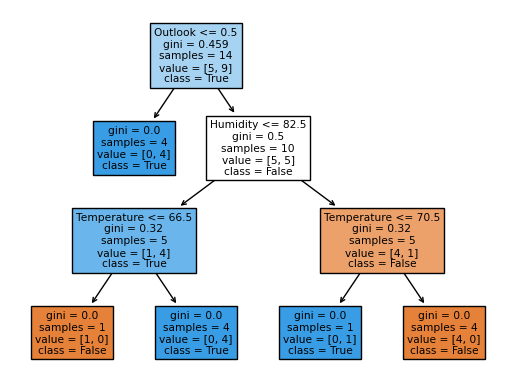

In [16]:
from matplotlib import pyplot as plt
fig = tree.plot_tree(clf, 
                   feature_names = X_train_num.columns.values,
                   class_names = ['False','True'],
                   filled=True)

### Evaluating model with new instance

In [17]:
# sunny:2, hot:85, normal:65, strong:0 
new_example = [[2, 60, 65, 1]]
X_test = pd.DataFrame(new_example, columns = ['Outlook', 'Temperature', 'Humidity', 'Wind'])
print(X_test)
clf.predict(X_test)

   Outlook  Temperature  Humidity  Wind
0        2           60        65     1


array([False])